In [1]:
import json
import time
from enum import IntEnum
from queue import Queue

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pretty_midi
import scipy
from tqdm import tqdm

from utils import MockAudioStream

In [2]:
SAMPLE_RATE = 44100
FRAME_RATE = 30
HOP_LENGTH = SAMPLE_RATE // FRAME_RATE
N_FFT = 2 * HOP_LENGTH
N_MELS = 66
NORM = np.inf
FRAME_PER_SEG = 1
WINDOW_SIZE = 3  # seconds
DEFAULT_LOCAL_COST = "euclidean"
MAX_RUN_COUNT = 30
FEATURE_TYPE = "chroma"  # option: ["chroma", "chroma_decay"]

In [3]:
def get_score_features(score_path: str, frame_rate: int = FRAME_RATE) -> np.ndarray:
    mid = pretty_midi.PrettyMIDI(score_path)
    chroma = mid.get_chroma(fs=frame_rate)
    chroma_norm = librosa.util.normalize(chroma)
    return chroma_norm.T  # (time, n_chroma)


def transfer_positions(wp, ref_anns):
    x, y = wp[0], wp[1]
    predicted_targets = [y[np.where(x >= r)[0][0]] for r in ref_anns]
    return predicted_targets

In [4]:
class Direction(IntEnum):
    REF = 0
    TARGET = 1

    def toggle(self):
        return Direction(self ^ 1)


class OLTW:
    """
    On-line Dynamic Time Warping (OLTW) algorithm for aligning a input sequence to a reference sequence.

    Parameters
    ----------
    reference_features : np.ndarray
        A 2D array with dimensions (`T(n_timesteps)`, `F(n_features)`) containing the
        features of the reference the input is going to be aligned to.

    queue : Queue
        A queue for storing the input features, which shares the same object as the audio stream.

    window_size : int
        Size of the window (in seconds) for searching the optimal path in the cost matrix.

    local_cost_fun : str
        Local metric for computing pairwise distances.
        
    max_run_count : int
        Maximum number of times the class can run in the same direction.

    frame_per_seg : int
        Number of frames per segment (audio chunk). default is 1.

    frame_rate : int
        Frame rate of the audio stream.

    Attributes
    ----------
    warping_path : np.ndarray [shape=(2, T)]
        Warping path with pairs of indices of the reference and target features.
        where warping_path[0] is the index of the reference feature and warping_path[1] is the index of the target(input) feature.
    """
    def __init__(
        self,
        reference_features,
        queue,
        window_size=WINDOW_SIZE,
        local_cost_fun=DEFAULT_LOCAL_COST,
        max_run_count=MAX_RUN_COUNT,
        frame_per_seg=FRAME_PER_SEG,
        frame_rate=FRAME_RATE,
        **kwargs,
    ):
        self.reference_features = reference_features
        self.N_ref = self.reference_features.shape[0]
        self.input_features = np.empty((0, self.reference_features.shape[1]))
        self.w = int(window_size * frame_rate)
        self.local_cost_fun = local_cost_fun
        self.max_run_count = max_run_count
        self.frame_per_seg = frame_per_seg
        self.current_position = 0
        self.wp = np.array([[0, 0]]).T  # [shape=(2, T)]
        self.queue = queue
        self.ref_pointer = 0
        self.input_pointer = 0
        self.input_index: int = 0
        self.run_count = 0
        self.previous_direction = None
        self.last_queue_update = time.time()

    @property
    def warping_path(self):  # [shape=(2, T)]
        return self.wp

    def offset(self):
        offset_x = max(self.ref_pointer - self.w, 0)
        offset_y = max(self.input_pointer - self.w, 0)
        return np.array([offset_x, offset_y])

    def init_matrix(self):
        x = self.ref_pointer
        y = self.input_pointer
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)
        new_acc = np.zeros((wx, wy))
        new_len_acc = np.zeros((wx, wy))
        x_seg = self.reference_features[x - wx : x]  # [wx, 12]
        y_seg = self.input_features[min(y - d, 0) : y]  # [d, 12]
        dist = scipy.spatial.distance.cdist(
            x_seg, y_seg, metric=self.local_cost_fun
        )  # [wx, d]

        for i in range(wx):
            for j in range(d):
                local_dist = dist[i, j]
                update_x0 = 0
                update_y0 = wy - d
                if i == 0 and j == 0:
                    new_acc[i, j] = local_dist
                elif i == 0:
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i, update_y0 - 1]
                    new_len_acc[i, update_y0 + j] = 1 + new_len_acc[i, update_y0 - 1]
                elif j == 0:
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i - 1, update_y0]
                    new_len_acc[i, update_y0 + j] = (
                        local_dist + new_len_acc[i - 1, update_y0]
                    )
                else:
                    compares = [
                        new_acc[i - 1, update_y0 + j],
                        new_acc[i, update_y0 + j - 1],
                        new_acc[i - 1, update_y0 + j - 1] * 0.98,
                    ]
                    len_compares = [
                        new_len_acc[i - 1, update_y0 + j],
                        new_len_acc[i, update_y0 + j - 1],
                        new_len_acc[i - 1, update_y0 + j - 1],
                    ]
                    local_direction = np.argmin(compares)
                    new_acc[i, update_y0 + j] = local_dist + compares[local_direction]
                    new_len_acc[i, update_y0 + j] = 1 + len_compares[local_direction]
        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc
        self.select_candidate()

    def update_accumulate_matrix(self, direction):
        # local cost matrix
        x = self.ref_pointer
        y = self.input_pointer
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)
        new_acc = np.zeros((wx, wy))
        new_len_acc = np.zeros((wx, wy))

        if direction is Direction.REF:
            new_acc[:-d, :] = self.acc_dist_matrix[d:]
            new_len_acc[:-d, :] = self.acc_len_matrix[d:]
            x_seg = self.reference_features[x - d : x]  # [d, 12]
            y_seg = self.input_features[y - wy : y]  # [wy, 12]
            dist = scipy.spatial.distance.cdist(
                x_seg, y_seg, metric=self.local_cost_fun
            )  # [d, wy]

            for i in range(d):
                for j in range(wy):
                    local_dist = dist[i, j]
                    update_x0 = wx - d
                    update_y0 = 0
                    if j == 0:
                        new_acc[update_x0 + i, j] = (
                            local_dist + new_acc[update_x0 + i - 1, j]
                        )
                        new_len_acc[update_x0 + i, j] = (
                            new_len_acc[update_x0 + i - 1, j] + 1
                        )
                    else:
                        compares = [
                            new_acc[update_x0 + i - 1, j],
                            new_acc[update_x0 + i, j - 1],
                            new_acc[update_x0 + i - 1, j - 1] * 0.98,
                        ]
                        len_compares = [
                            new_len_acc[update_x0 + i - 1, j],
                            new_len_acc[update_x0 + i, j - 1],
                            new_len_acc[update_x0 + i - 1, j - 1],
                        ]
                        local_direction = np.argmin(compares)
                        new_acc[update_x0 + i, j] = (
                            local_dist + compares[local_direction]
                        )
                        new_len_acc[update_x0 + i, j] = (
                            1 + len_compares[local_direction]
                        )

        elif direction is Direction.TARGET:
            overlap_y = wy - d
            new_acc[:, :-d] = self.acc_dist_matrix[:, -overlap_y:]
            new_len_acc[:, :-d] = self.acc_len_matrix[:, -overlap_y:]
            x_seg = self.reference_features[x - wx : x]  # [wx, 12]
            y_seg = self.input_features[y - d : y]  # [d, 12]
            dist = scipy.spatial.distance.cdist(
                x_seg, y_seg, metric=self.local_cost_fun
            )  # [wx, d]

            for i in range(wx):
                for j in range(d):
                    local_dist = dist[i, j]
                    update_x0 = 0
                    update_y0 = wy - d
                    if i == 0:
                        new_acc[i, update_y0 + j] = (
                            local_dist + new_acc[i, update_y0 - 1]
                        )
                        new_len_acc[i, update_y0 + j] = (
                            1 + new_len_acc[i, update_y0 - 1]
                        )
                    else:
                        compares = [
                            new_acc[i - 1, update_y0 + j],
                            new_acc[i, update_y0 + j - 1],
                            new_acc[i - 1, update_y0 + j - 1] * 0.98,
                        ]
                        len_compares = [
                            new_len_acc[i - 1, update_y0 + j],
                            new_len_acc[i, update_y0 + j - 1],
                            new_len_acc[i - 1, update_y0 + j - 1],
                        ]
                        local_direction = np.argmin(compares)
                        new_acc[i, update_y0 + j] = (
                            local_dist + compares[local_direction]
                        )
                        new_len_acc[i, update_y0 + j] = (
                            1 + len_compares[local_direction]
                        )
        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc

    def update_path_cost(self, direction):
        self.update_accumulate_matrix(direction)
        self.select_candidate()

    def select_candidate(self):
        norm_x_edge = self.acc_dist_matrix[-1, :] / self.acc_len_matrix[-1, :]
        norm_y_edge = self.acc_dist_matrix[:, -1] / self.acc_len_matrix[:, -1]
        cat = np.concatenate((norm_x_edge, norm_y_edge))
        min_idx = np.argmin(cat)
        offset = self.offset()
        if min_idx <= len(norm_x_edge):
            self.candidate = np.array([self.ref_pointer - offset[0], min_idx])
        else:
            self.candidate = np.array(
                [min_idx - len(norm_x_edge), self.input_pointer - offset[1]]
            )

    def save_history(self):
        new_coordinate = np.expand_dims(
            self.offset() + self.candidate, axis=1
        )  # [2, 1]
        self.wp = np.concatenate((self.wp, new_coordinate), axis=1)

    def select_next_direction(self):
        if self.input_pointer <= self.w:
            next_direction = Direction.TARGET
        elif self.run_count > self.max_run_count:
            next_direction = self.previous_direction.toggle()
        else:
            offset = self.offset()
            x0, y0 = offset[0], offset[1]
            if self.candidate[0] == self.ref_pointer - x0:
                next_direction = Direction.REF
            else:
                assert self.candidate[1] == self.input_pointer - y0
                next_direction = Direction.TARGET
        return next_direction

    def get_new_input(self):
        target_feature = self.queue.get()
        q_length = self.frame_per_seg
        self.input_features = np.vstack([self.input_features, target_feature])
        self.input_pointer += q_length
        self.last_queue_update = time.time()

    def is_still_following(self):
        is_still_following = self.ref_pointer <= (self.N_ref - self.frame_per_seg)
        return is_still_following

    def run(self, verbose=False):
        print(f"\nStart running OLTW with distance func: {self.local_cost_fun}")
        if verbose:
            fig = plt.figure(figsize=(16, 2))
            ax = fig.gca()
            hfig = display(fig, display_id=True)
            h = ax.imshow(
                np.zeros((self.reference_features.shape[1], int(self.N_ref * 1.2))),
                aspect="auto",
                vmin=0,
                vmax=1,
                interpolation="nearest",
            )
        self.ref_pointer += self.w
        self.get_new_input()
        self.init_matrix()

        pbar = tqdm(total=self.N_ref)
        while self.is_still_following():
            updated_position = self.wp[0][-1]
            pbar.update(updated_position - self.current_position)
            pbar.set_description(
                f"[{self.ref_pointer}/{self.N_ref}] ref: {self.ref_pointer}, input: {self.input_pointer}"
            )
            self.current_position = updated_position
            self.save_history()
            direction = self.select_next_direction()

            if direction is Direction.TARGET:
                self.get_new_input()
                if verbose and fig:
                    current_data = h.get_array()
                    current_data[:, self.input_pointer] = self.input_features[-1]
                    h.set_data(current_data)
                    hfig.update(fig)
            elif direction is Direction.REF:
                self.ref_pointer += self.frame_per_seg

            self.update_path_cost(direction)

            if direction == self.previous_direction:
                self.run_count += 1
            else:
                self.run_count = 1

            self.previous_direction = direction
            self.input_index += 1

        pbar.close()

        return self.wp

## Run the Score Following (Live Simulation)
For reproducible evaluation (independent of hardware issues like microphones), we provide a live simulation mode. This mode uses a pre-recorded performance audio file as input to the model.

* [Mocking] Loading existing audio file(./resources/ex_perf.wav)....
Start running OLTW with distance func: euclidean



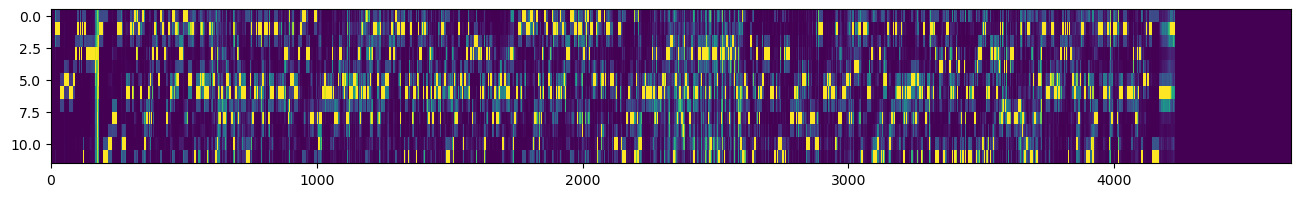

/Users/jiyun/.pyenv/versions/mambaforge/envs/match/lib/python3.12/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/var/folders/qt/9fbsg60j1nq11b6lhq5t9zrm0000gn/T/ipykernel_75111/2224581415.py:226: RuntimeWarning: invalid value encountered in divide
  norm_y_edge = self.acc_dist_matrix[:, -1] / self.acc_len_matrix[:, -1]
[3886/3887] ref: 3886, input: 4225: 100%|█████████▉| 3885/3887 [02:18<00:00, 27.95it/s]  


=====================oltw run ended=====================


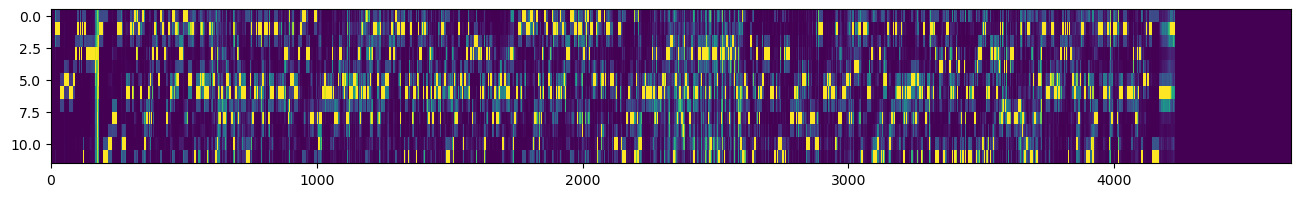

In [5]:
score_path = "./resources/ex_score.mid"
perf_path = "./resources/ex_perf.wav"


def run_score_following(score_path, perf_path):
    reference_features = get_score_features(score_path)
    queue = Queue()

    oltw = OLTW(
        reference_features=reference_features,
        queue=queue,
        local_cost_fun=DEFAULT_LOCAL_COST,
        window_size=WINDOW_SIZE,
        max_run_count=MAX_RUN_COUNT,
        frame_per_seg=FRAME_PER_SEG,
        frame_rate=FRAME_RATE,
    )
    perf_stream = MockAudioStream(
        queue=queue,
        feature_type=FEATURE_TYPE,
        sample_rate=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        chunk_size=FRAME_PER_SEG,
        file_path=perf_path,
    )

    # Start the performance stream
    perf_stream.start()
    warping_path = oltw.run(verbose=True)
    print(f"=====================oltw run ended=====================")

    perf_stream.stop()
    return oltw, warping_path


oltw, warping_path = run_score_following(score_path, perf_path)

## Run Evaluation

We use the beat-level annotations of the performance audio to evaluate the model. The sample files are all from the [ASAP](https://github.com/fosfrancesco/asap-dataset) dataset.

In [6]:
TOLERANCES = [50, 100, 200, 300, 500, 1000]  # in milliseconds
score_ann = "./resources/ex_score_annotations.txt"
perf_ann = "./resources/ex_perf_annotations.txt"

def run_evaluation(wp, ref_ann, target_ann, frame_rate):
    ref_annots = np.rint(
        pd.read_csv(filepath_or_buffer=ref_ann, delimiter="\t", header=None)[0]
        * frame_rate
    )
    target_annots = np.rint(
        pd.read_csv(filepath_or_buffer=target_ann, delimiter="\t", header=None)[0]
        * frame_rate
    )

    target_annots_predicted = transfer_positions(wp, ref_annots)
    errors_in_delay = (
        (target_annots - target_annots_predicted) / frame_rate * 1000
    )  # in milliseconds

    absolute_errors_in_delay = np.abs(errors_in_delay)
    filtered_abs_errors_in_delay = absolute_errors_in_delay[
        absolute_errors_in_delay <= TOLERANCES[-1]
    ]

    results = {
        "mean": float(f"{np.mean(filtered_abs_errors_in_delay):.4f}"),
        "median": float(f"{np.median(filtered_abs_errors_in_delay):.4f}"),
        "std": float(f"{np.std(filtered_abs_errors_in_delay):.4f}"),
        "skewness": float(f"{scipy.stats.skew(filtered_abs_errors_in_delay):.4f}"),
        "kurtosis": float(f"{scipy.stats.kurtosis(filtered_abs_errors_in_delay):.4f}"),
    }
    for tau in TOLERANCES:
        results[f"{tau}ms"] = float(f"{np.mean(absolute_errors_in_delay <= tau):.4f}")
    print(f"Evaluation Results: {json.dumps(results, indent=4)}")
    return results

results = run_evaluation(warping_path, score_ann, perf_ann, FRAME_RATE)

Evaluation Results: {
    "mean": 91.1616,
    "median": 66.6667,
    "std": 92.4653,
    "skewness": 7.1854,
    "kurtosis": 67.8964,
    "50ms": 0.2426,
    "100ms": 0.7426,
    "200ms": 0.9559,
    "300ms": 0.9632,
    "500ms": 0.9632,
    "1000ms": 0.9706
}


## Feature Visualization

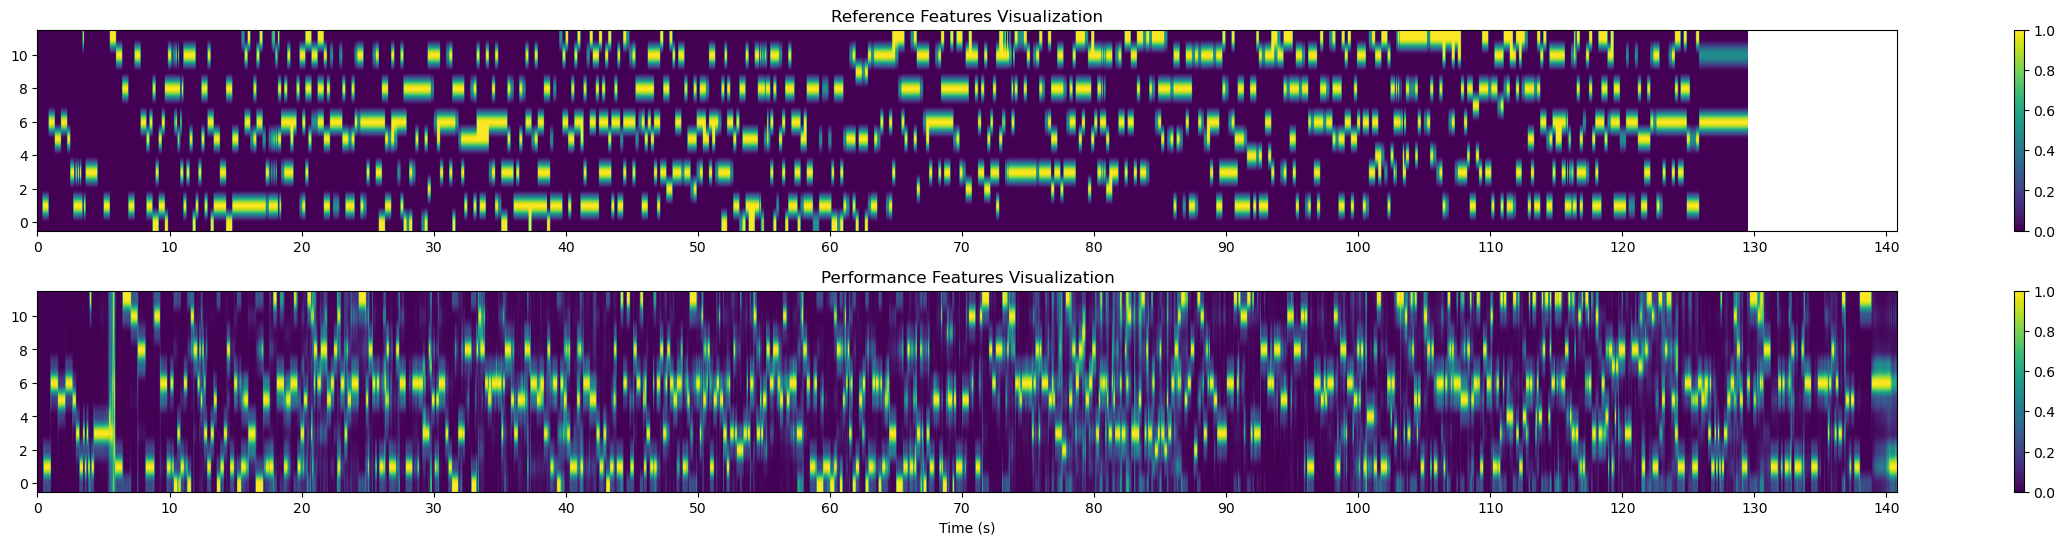

In [7]:
max_step = np.max((oltw.ref_pointer, oltw.input_pointer))
max_x_time = max_step / FRAME_RATE

x_ticks = np.arange(0, max_x_time, 10)
x_labels = [f"{x:.0f}" for x in x_ticks]

plt.figure(figsize=(30, 6))

# First subplot
plt.subplot(211)
plt.title("Reference Features Visualization")
plt.imshow(oltw.reference_features.T, aspect="auto", origin="lower")
plt.xlim(0, max_step)
plt.colorbar()
plt.xticks(ticks=x_ticks * FRAME_RATE, labels=x_labels)

# Second subplot
plt.subplot(212)
plt.title("Performance Features Visualization")
plt.imshow(oltw.input_features.T, aspect="auto", origin="lower")
plt.xlim(0, max_step)
plt.colorbar()
plt.xticks(ticks=x_ticks * FRAME_RATE, labels=x_labels)
plt.xlabel("Time (s)")

plt.subplots_adjust(hspace=0.3)
plt.show()

## Accumulated distance matrix with warping path & ground-truth labels

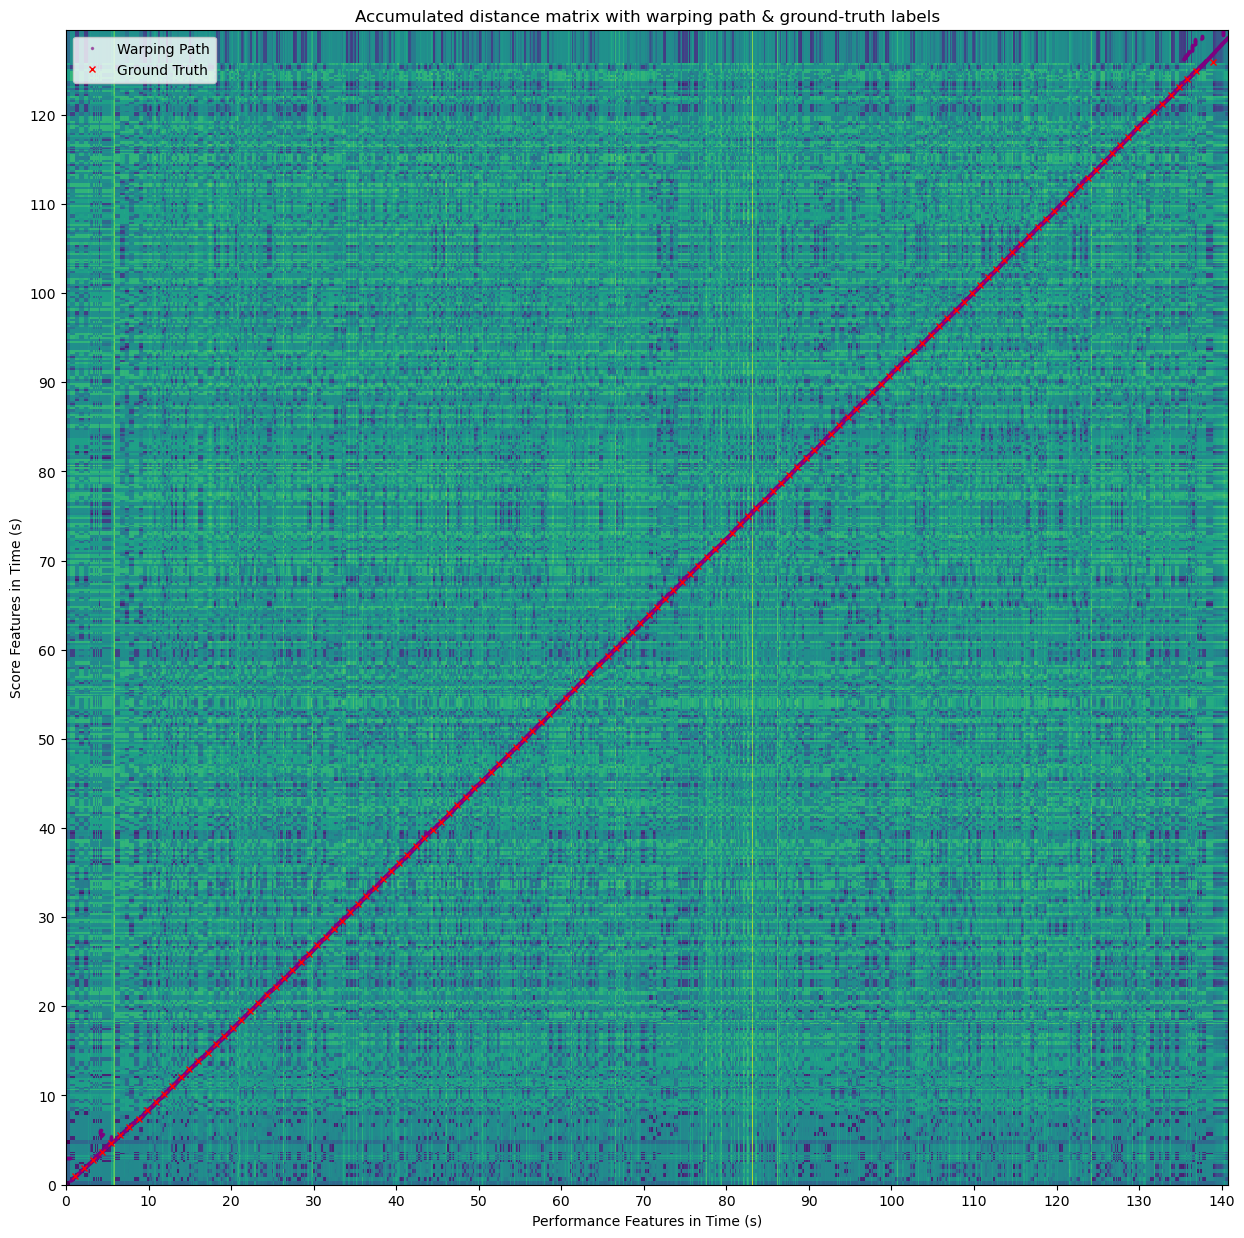

In [8]:
dist = scipy.spatial.distance.cdist(
    oltw.reference_features,
    oltw.input_features,
    metric=oltw.local_cost_fun,
)  # [d, wy]

plt.figure(figsize=(15, 15))
plt.imshow(dist, aspect="auto", origin="lower", interpolation="nearest")
plt.title("Accumulated distance matrix with warping path & ground-truth labels")
plt.xlabel("Performance Features in Time (s)")
plt.ylabel("Score Features in Time (s)")

max_x_time = dist.shape[1] / FRAME_RATE
max_y_time = dist.shape[0] / FRAME_RATE
x_ticks = np.arange(0, max_x_time, 10)
y_ticks = np.arange(0, max_y_time, 10)
x_labels = [f"{x:.0f}" for x in x_ticks]
y_labels = [f"{y:.0f}" for y in y_ticks]

plt.xticks(ticks=x_ticks * FRAME_RATE, labels=x_labels)
plt.yticks(ticks=y_ticks * FRAME_RATE, labels=y_labels)

# plot warping path
ref_paths, perf_paths = warping_path[0], warping_path[1]
for n in range(len(ref_paths)):
    plt.plot(
        perf_paths[n],
        ref_paths[n],
        ".",
        color="purple",
        alpha=0.5,
        markersize=3,
        label="Warping Path" if n == 0 else "",
    )

# plot ground-truth labels
ref_annots = pd.read_csv(filepath_or_buffer=score_ann, delimiter="\t", header=None)[0]
target_annots = pd.read_csv(filepath_or_buffer=perf_ann, delimiter="\t", header=None)[0]
for i, (ref, target) in enumerate(zip(ref_annots, target_annots)):
    plt.plot(
        target * FRAME_RATE,
        ref * FRAME_RATE,
        "x",
        color="r",
        alpha=1,
        markersize=5,
        label="Ground Truth" if i == 0 else "",
    )

plt.legend()
plt.show()